# <center>**Machine Learning Report**</center>

## 1.1 Overview 

This report provides a detailed explanation of the data processing, model selection, model comparison, and storage and usage of models in the machine learning part of this project, along with relevant code.<br/>

<br/>
The final result is 114 trained Linear Regression models for each station, saved as joblib files in the "ML_models" folder.


## 1.2 Package Import

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
from joblib import dump
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# hide ipykernel warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1.3 Data Preparation 

About the data processing part:

1. First, align the table containing station information and the table containing weather information based on the timestamp and join them.
Initially, constant items and null values in the database were checked: constant items were discarded as they do not affect predictions; no action was taken on null values as there were none.
2. Processing time-related features: Convert timestamps to datetime type, then extract the day of the week (1~7 corresponding to Monday to Sunday) and hour as new features added to the data frame.
3. Select significant features: Discard columns such as weather_description, weather_icon, and wind_deg that do not contain much information or have minimal variation close to constant features.
4. Check the types of features and modify inappropriate ones. Finally, treat station_id, weather_id, hour, and day_of_week as categorical features, and the rest as numerical features.
---

*The specific operations for this section can be found in the support_material section's data_preparation.ipynb.*<br/>
*The cleaned data is saved as cleaned_data.csv and imported.*






In [4]:
df_merged = pd.read_csv('cleaned_data.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [5]:
df_merged.head(5)

,station_id,available_bikes,weather_id,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds,total_bike_stands,hour,day_of_week
0,96,12,802,8.85,4.98,8.27,9.37,1000,68,8.75,40,30,13,4
1,51,8,802,8.85,4.98,8.27,9.37,1000,68,8.75,40,40,13,4
2,61,7,802,8.85,4.98,8.27,9.37,1000,68,8.75,40,25,13,4
3,76,1,802,8.85,4.98,8.27,9.37,1000,68,8.75,40,38,13,4
4,11,14,802,8.85,4.98,8.27,9.37,1000,68,8.75,40,30,13,4


In [6]:
latest_data = df_merged.groupby('station_id').apply(lambda x: x.tail(1))
latest_data = latest_data[['station_id', 'total_bike_stands']]
station_dict = dict(zip(latest_data['station_id'], latest_data['total_bike_stands']))
print(station_dict)
keys_list = list(station_dict.keys())


print(type(keys_list[0]))

{1: 31, 2: 20, 3: 20, 4: 20, 5: 40, 6: 20, 7: 29, 8: 30, 9: 23, 10: 16, 11: 30, 12: 20, 13: 30, 14: 30, 15: 16, 16: 20, 17: 20, 18: 30, 19: 30, 20: 30, 21: 30, 22: 20, 23: 30, 24: 20, 25: 30, 26: 20, 27: 20, 28: 30, 29: 28, 30: 18, 31: 20, 32: 29, 33: 23, 34: 30, 35: 30, 36: 39, 37: 30, 38: 40, 39: 20, 40: 21, 41: 20, 42: 30, 43: 30, 44: 30, 45: 30, 47: 40, 48: 40, 49: 40, 50: 40, 51: 40, 52: 32, 53: 40, 54: 33, 55: 36, 56: 40, 57: 23, 58: 40, 59: 20, 60: 30, 61: 25, 62: 40, 63: 35, 64: 40, 65: 40, 66: 39, 67: 40, 68: 40, 69: 40, 71: 40, 72: 31, 73: 30, 74: 30, 75: 39, 76: 38, 77: 29, 78: 40, 79: 27, 80: 40, 82: 22, 83: 40, 84: 30, 85: 35, 86: 38, 87: 38, 88: 30, 89: 40, 90: 40, 91: 30, 92: 40, 93: 40, 94: 40, 95: 40, 96: 30, 97: 40, 98: 40, 99: 30, 100: 25, 101: 30, 102: 40, 103: 40, 104: 40, 105: 36, 106: 40, 107: 40, 108: 35, 109: 29, 110: 40, 111: 40, 112: 30, 113: 40, 114: 40, 115: 30, 116: 30, 117: 40}
<class 'int'>


In [7]:
stations = df_merged["station_id"].unique()

models = {}
if not os.path.exists("ML_models"):
    os.makedirs("ML_models")

print(stations)

[ 96  51  61  76  11  41 111 101  47 117  36  57  86  97 107   7  13  37
 106  53  93 112  63  16  56 103  78  87 113  79  59   4  94  73  72 108
  99  18  82  24  74  44   1  89  84   6  52 110  34  29 105  17  80  15
  91  45  20  21  64  54 114  50  75  92  55  65  98  62  90   2  33  60
 116  43  49  25  10  88   9  19   5  85  68  58 109  67  35  32  71  95
  83 104  42  69  77   8  40  28 115  12  27 100  31  22  23  26  39  30
  38  48  66 102   3  14]


## 1.4 Machine Learning Model

### 1.4.1 Model Discussion

Because the goal is to predict specific bike counts, regression models would be more appropriate than classification models. Therefore, you're considering linear regression, decision tree regression, random forest regression, and K-Nearest Neighbors (KNN), while not considering Logistic Regression

---
**Models analysis:**
1. Linear Regression:

- Suitable for data with relatively linear relationships.
- Pros: Simple model, easy to understand and implement.
- Cons: May not handle non-linear relationships well.

2. Random Forest Regression:

- Suitable for handling complex non-linear problems and less prone to overfitting.
- Pros: Can automatically handle interactions between features, adapts well to complex data structures.
- Cons: Larger model size, longer training time, and less interpretable compared to linear regression.

3. Decision Tree Regression:

- Suitable for data with non-linear relationships and when model interpretability is important.
- Pros: Generated model is easy to understand, simple to implement.
- Cons: Prone to overfitting, sensitive to small variations in data.

4. K-Nearest Neighbors (KNN):

- Suitable for practical problems where parameter forms are difficult to determine.
- Pros: Simple algorithm structure, easy to understand and implement.
- Cons: Performance may not be as good as some other advanced machine learning algorithms when faced with complex and high-dimensional data.

*Because I believe there are significant differences in bike usage patterns between different stations, I plan to train models separately for each of the 114 stations.* <br/>
*Due to the large size of the result files for the random forest model, I have decided not to use this model for now.*

---

**Test set selection:** <br/>
Because randomly sampling training and testing data can lead to data leakage issues, affecting the accuracy of model evaluation, I opted to split the dataset into a 7:3 ratio for training and testing data.

---
**Evaluation of prediction results:**<br/>
I will use Mean Squared Error (MSE) and the coefficient of determination (R²) as evaluation metrics. By calculating the average MSE and R² across the 114 models, I can assess the overall predictive performance of the models.



### 1.4.2 Model Trainning Function

In [3]:

def process_station_data(df_merged, station, model_type):
    df_station = df_merged[df_merged["station_id"] == station]
    X = df_station.drop(["available_bikes", "station_id"], axis=1)
    y = df_station["available_bikes"]
    categorical_features = ['weather_id', 'hour', 'day_of_week']
    numerical_features = X.drop(columns=categorical_features).columns

    test_size = int(len(X) * 0.3)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN": KNeighborsRegressor(),
        "DecisionTree": DecisionTreeRegressor(max_depth=5, random_state=42)
    }

    if model_type not in models:
        raise ValueError(f"Unsupported model type {model_type}. Choose from 'Linear Regression', 'Random Forest', 'KNN'")

    model = models[model_type]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if station == 1:
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
        plt.xlabel("Actual Number of Bikes")
        plt.ylabel("Predicted Number of Bikes")
        plt.title(f"{model_type}: Actual vs Predicted")
        plt.show()

    return mse, r2



### 1.4.3 Model Testing

#### **Linear Regression model**

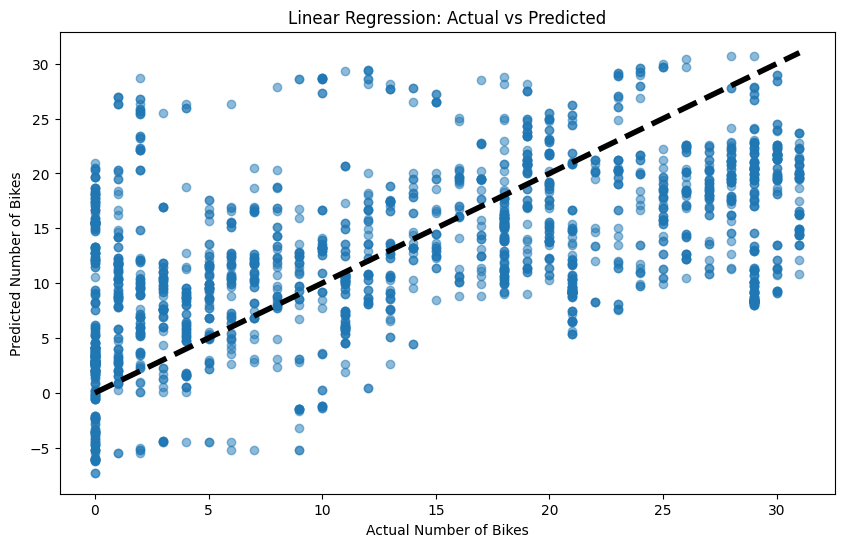

Average Mean Squared Error across all stations for Linear Regression: 90.27725443555626
Average R^2 Score across all stations for Linear Regression: -0.8444604803881244


In [9]:
model_to_use = "Linear Regression"

mse_scores = []
r2_scores = []

for station in stations:
    mse, r2 = process_station_data(df_merged, station, model_to_use)
    mse_scores.append(mse)
    r2_scores.append(r2)

average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)
print(f"Average Mean Squared Error across all stations for {model_to_use}: {average_mse}")
print(f"Average R^2 Score across all stations for {model_to_use}: {average_r2}")

#### **Decision Tree model**

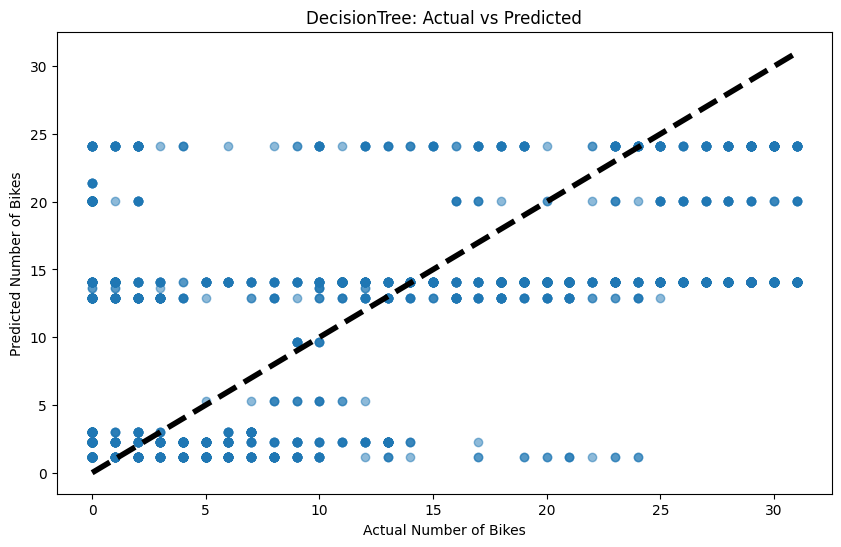

Average Mean Squared Error across all stations for DecisionTree: 109.14483657772406
Average R^2 Score across all stations for DecisionTree: -1.134852386216978


In [10]:
model_to_use = "DecisionTree"

mse_scores = []
r2_scores = []

for station in stations:
    mse, r2 = process_station_data(df_merged, station, model_to_use)
    mse_scores.append(mse)
    r2_scores.append(r2)

average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)
print(f"Average Mean Squared Error across all stations for {model_to_use}: {average_mse}")
print(f"Average R^2 Score across all stations for {model_to_use}: {average_r2}")

#### **KNN model**

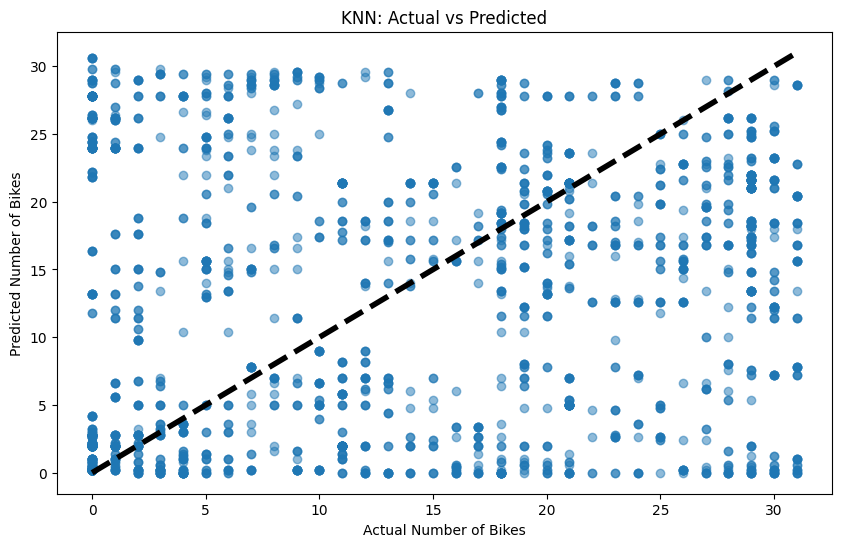

Average Mean Squared Error across all stations for KNN: 111.54992208040537
Average R^2 Score across all stations for KNN: -1.0916579245338103


In [11]:
model_to_use = "KNN" # or "Linear Regression", "Random Forest"

mse_scores = []
r2_scores = []

for station in stations:
    mse, r2 = process_station_data(df_merged, station, model_to_use)
    mse_scores.append(mse)
    r2_scores.append(r2)

average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)
print(f"Average Mean Squared Error across all stations for {model_to_use}: {average_mse}")
print(f"Average R^2 Score across all stations for {model_to_use}: {average_r2}")

#### **Results**

From the results, it appears that the linear regression model performs the best among these models. Therefore, we choose the linear regression model as our predictive model.

### 1.4.4 Model Saving

We will use a Pipeline to save the preprocessor along with the respective model files, storing them in the "ML_models" folder with the site ID information as the model name tag.

In [12]:
from sklearn.pipeline import Pipeline

for station in stations:
    df_station = df_merged[df_merged["station_id"] == station]

    X = df_station.drop(
        ["available_bikes", "station_id"],
        axis=1,
    )
    y = df_station["available_bikes"]
    categorical_features = ['weather_id', 'hour', 'day_of_week']
    numerical_features = X.drop(columns=categorical_features).columns

    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    test_size = int(len(X) * 0.3)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]
    model_pipeline.fit(X_train, y_train)

    # Serialize model
    dump(model_pipeline, f"ML_models/model{station}.joblib")